In [1]:
import numpy as np
from numpy import linalg
import sympy as sp
from sympy import *
import math
import random
import fractions
from matplotlib import pyplot as plt
from time import time
from fractions import Fraction
from IPython.display import display, Latex

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# LINEAR ALGEBRA HOMEWORK SOLVER

### by Jason Zhou jason.zhou@duke.edu

This python notebook is meant to assist the user in solving linear algebra problems, most likely in a homework context. The contents are based loosely off of the class MATH218 taught at Duke by Professor Joe Rabinoff and Professor Rann Bar-On. It differs from other similar services by offering the following special features:

1. Showing steps

2. Supporting fractions

3. Modular Functions that can be editted

4. Functions can be used in conjunction with each other

5. Detailed documentation and explanation of algorithms

6. Less visual but much more efficient input UI

7. No latency and does not require internet connection

8. Large number of functions all in one place. Majority of functions in an entry level linear algebra class are included

9. Aesthetic LaTex output

What this jupyter notebook is:

1. A homework assistant that automates computation
2. A teaching tool that demonstrates linear algebra algorithms
3. A quick and dirty linear algebra textbook
4. Sympy that shows steps

What this jupyter notebook is not:

1. A replacement for numpy
2. A tool to process large amounts of information in contexts such as machine learning

Notes on known bugs and performance issues:

1. Jupyter notebooks uses MathJax to render latex outputs. When running the entire notebook for the first time it will take a few seconds for latex outputs to render if you see unrendered latex, do not panic it will resolve itself soon.

2. Some of the rendered outputs will create a scroll wheel next to it often when its displaying a matrix with fractional values inside. Theres nothing I can figure out to deal with this annoying issue.

3. When viewing in github some values show up as UnknownValue when they fail to render, this issue is fixed when opening the file in jupyter notebook or vscode.

# USER GUIDE

The packages should already be preinstalled if you are running on jupyter notebook. Please run the entire notebook before attempting to use a specific function as many of the functions are reliant on others. When running the whole notebook, it will take several seconds for the latex outputs to fully render, if you see raw latex do not panic.

For standardization purposes the following guidelines

To enter the vector:

$$v=\begin{bmatrix}1\\ 2 \\ 3\end{bmatrix}$$

write:

```python
                                                   v = np.array([1, 2, 3])
```

To enter the matrix:

$$A=\begin{bmatrix}
1 & 2 & 3 & 4\\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & l2
\end{bmatrix}$$

write:

```python
                                                   A = np.array([[1, 2, 3, 4],
                                                                 [5, 6, 7, 8],
                                                                 [9, 10, 11, 12]])
```
Remember that python and numpy index starting from 0, so the first row of A would be A[0]. However, for increased intuitiveness the print statements of the functions in this notebook index starting from 1. So the first row of A would be called row 1 in the print statements(actual computation is still done with indexing starting from 0).
Notes on fractional values:

This notebook uses sympy to handle many fraction cases. In order to enter a fraction see example below

The fraction: 

$$a = \frac{1}{2}$$

becomes:

```python
                                                      a = Rational(1, 2)
```

array objects can be inputted with fractions.
the vector:

$$v=\begin{bmatrix}\frac{1}{2} \\ \frac{1}{3} \\ \frac{1}{4} \end{bmatrix}$$

becomes:

```python
                                   v = np.array([Rational(1, 2), Rational(1,3), Rational(1, 4)])
```

Be wary that the preprocessing function used in this notebook will do its best to convert all numbers into sympy objects in order to facilitate true algebra. Do not enter 0.6666666666 thinking it will give you $$\frac{2}{3}$$ it will instead convert this float into $$\frac{6004799502560181}{9007199254740992}$$.

Sympy also allows us to enter symbols

To enter the variables:

$$x, y, z$$

write
```python
                                   x, y, z = symbols('x y z')
```


numpy is also capable of handling imaginary values
the vector
$$v=\begin{bmatrix}1 + i\\ 2i \\ \frac{3}{i}\end{bmatrix}$$
becomes
```python
                                   v = np.array([1 + 1j, 2j, Rational(3, 1j)])
```
note that i is called j in numpy and requires a coefficient to initiate even if it is 1. For this reason, avoid using j as a symbol name

# TABLE OF CONTENTS

0. General Use
1. Numpy Built-ins
2. Human Algorithm Row Reducer
3. Linear Dependence
4. Rank
5. LU Decomposition
6. Determinant
7. Inverse
8. Area of a Parallelogram
9. Volume of a Parallelopiped
10. Orthogonality
11. Least Squares
12. Trace
13. QR Decomposition
14. Eigenvalues and Eigenvectors
15. Diagonalization

# 0. GENERAL USE

Some functions to facilitate the operation of other functions.

In [3]:
def preprocess(A):
    """
    The goal of preprocess is to create a copy of array A,
    such that all the values of A are ideally represented
    by sp.core.numbers.Rational objects. This is to allow
    the functions to perform algebra instead of approximating
    float representations of rationals.
    Parameters
    ----------
    A: array_like
        Matrix to be processed
    Returns
    -------
    R: array_like
        A copy of A that has done its best to convert the values
        in A into sp.core.numbers.Rational objects if possible
    """
    Y = A.shape
    R = np.empty(Y, dtype = sp.core.numbers.Rational)
    if len(Y) == 1:
        #identified A as a vector 
        #so only one loop is needed to iterate through all values
        for i in range(Y[0]):
            if type(A[i]) == fractions.Fraction:
                R[i] = Rational(A[i].numerator, A[i].denominator)
            elif type(A[i]) in [int, float, np.int32, np.float64]:
                R[i] = Rational(A[i], 1)
            else:
                R[i] = A[i]
    else:
        #identified A as a matrix
        #two loops are needed to iterate through all values
        for i in range(Y[0]):
            for j in range(Y[1]):
                if type(A[i][j]) == fractions.Fraction:
                    R[i][j] = Rational(A[i][j].numerator, A[i][j].denominator)
                elif type(A[i][j]) in [int, float, np.int32, np.float64]:
                    R[i][j] = Rational(A[i][j], 1)
                else:
                    R[i][j] = A[i][j]
    return R

def swaprows(A,i,j):
    """
    Swaps rows i and j in a matrix
    Parameters
    ----------
    A: array_like
        Matrix to be changed
    i: int
        Row to be swapped
    j: int
        Row to be swapped
    Returns
    -------
    A: array_like
        Matrix now with swapped rows
    Notes
    -----
    Performs operation in place does not create a copy of A
    """
    A[[i,j]] = A[[j,i]]
    return A

def rowmult(A,i,c):
    """
    Multiply a row by a factor
    Parameters
    ----------
    A: array_like
        Matrix to be changed
    i: int
        Row to be multiplied
    c: float, int
        Constant to multiply by
    Returns
    -------
    A: array_like
        Matrix now with multiplied row
    Notes
    -----
    Performs operation in place does not create a copy of A
    """
    A[i] *= c
    return A

def rowaddmult(A,i,j,c=1):
    """
    Add a multiple of another row to a row
    Parameters
    ----------
    A: array_like
        Matrix to be changed
    i: int
        Row to be multiplied
    j: int
        Row to receive addition
    c: float, int
        Constant to multiply by
    Returns
    -------
    A: array_like
        Matrix now with a modified row
    Notes
    -----
    Performs operation in place does not create a copy of A
    """
    A[j] += c*A[i]
    return A

def random_matrix(m = 10, n = 10, rand_mxn = False, m_max = 10, m_min = 1, n_max = 10, n_min = 1, int_min = -10, int_max = 10):
    """
    Generates a matrix with random numbers inside. Used for testing.
    Parameters
    ----------
    m: int
        Number of rows in matrix
    n: int
        Number of columns in matrix
    rand_mxn: bool
        If True ignores variables m and n and generates a matrix based on other parameters
    m_min: int
        Smallest number of rows that can be randomly generated
    m_max: int
        Largest number of rows that can be randomly generated
    n_min: int
        Smallest number of columns that can be randomly generated
    n_max: int
        Largest number of columns that can be randomly generated
    int_min: int
        Smallest random integer that can be generated to fill matrix
    int_max: int
        Largest random integer that can be generated to fill matrix
    Returns
    -------
    A: array_like
        Randomly generated matrix
        
    """
    if rand_mxn:
        A = np.zeros([random.randint(m_min, m_max), random.randint(n_min, n_max)])
    else:
        A = np.zeros([m, n])
    Y = A.shape
    for i in range(Y[0]):
        for j in range(Y[1]):
            A[i][j] = float(random.randint(int_min, int_max))
    return A


# 1. NUMPY/SYMPY BUILT-IN FUNCTIONS

Numpy has many built in functions, as a general rule, one should use numpy functions if the special features provided by the functions in the notebook are not of use. Numpy runs much faster and more accurately(floating point minimization) than the functions in this notebook due to efficient algorithms.

First lets show how to display latex matrices

In [4]:
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
display(Latex('$$' + latex(sp.Matrix(A)) + '$$'))

<IPython.core.display.Latex object>

@ between 2 vectors returns the dot product

In [5]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
a @ b

32

@ between a matrix and a vector returns the matrix multiplied by the vector

In [6]:
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
b = np.array([10, 11, 12])
display(Latex('$$' + latex(sp.Matrix(A @ b)) + '$$'))

<IPython.core.display.Latex object>

@ between a matrix and a matrix returns the matrix multiplied by a matrix

In [7]:
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
B = np.array([[11, 12, 13],
              [14, 15, 16],
              [17, 18, 19]])
display(Latex('$$' + latex(sp.Matrix(A @ B)) + '$$'))

<IPython.core.display.Latex object>

the .T method of an array returns the transpose of a numpy array

In [8]:
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
display(Latex('$$' + latex(sp.Matrix(A.T)) + '$$'))

<IPython.core.display.Latex object>

np.cross(a, b) returns the cross product

In [9]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
display(Latex('$$' + latex(sp.Matrix(np.cross(a, b))) + '$$'))

<IPython.core.display.Latex object>

np.linalg.norm(a) returns the magnitude of a vector

In [10]:
a = np.array([1, 2, 3])
np.linalg.norm(a)

3.7416573867739413

The numpy linalg library also provides a myriad of functions such as np.linalg.eig(), np.linalg.qr(), np.linalg.svd(), np.linalg.solve(), np.linalg.det(), np.linalg.inv() etc., more information can be found on https://numpy.org/doc/stable/reference/routines.linalg.html. Functions for solving these problems are included in this python notebook, however if one is doing a serious application they should use the numpy linalg library. 

# 2. ROW REDUCTION

In [11]:
def rowred(A, rref = False, human = True, output = False):
    """
    Uses row operations until a matrix is in row echelon form. 
    It deals with 0 pivots by swapping rows with the next non-zero pivot row.
    Parameters
    ----------
    A: array_like
        Matrix to be row reduced
    rref: bool
        if True, rowred() will go to the full extent and return the 
        back substituted, reduced row echelon form
    human: bool
        if False, rowred() will swap rows until it finds the biggest possible pivot
    output: bool
        if True, rowred() will actually return A_clone
    Returns
    -------
    A_clone: array_like
        row echelon form or reduced row echelon form of A, only does so if output == True
        
    """
    Y = A.shape
    A_clone = preprocess(A)
    for i in range(Y[1]):
        if i < Y[0] and human == False:
            pivot = i + np.argmax(abs(A_clone[i:,i]))
            if pivot != i:                    
                swaprows(A_clone, pivot, i)
                print('Swapped row ' + str(i + 1) + ' with row ' + str(pivot + 1))
                display(Latex('$$' + latex(sp.Matrix(A_clone)) + '$$'))
        for j in range(i + 1, Y[0]):
            breaker = False
            if A_clone[i][i] == 0:
                breaker = True
                for k in range(i + 1,Y[0]):
                    if A_clone[k][i] != 0:
                        swaprows(A_clone, k, i)
                        print('Swapped row ' + str(i+1) + ' with row ' + str(k+1))
                        display(Latex('$$' + latex(sp.Matrix(A_clone)) + '$$'))
                        breaker = False
                        continue
            if breaker:
                break
            c = -(A_clone[j][i] / A_clone[i][i])
            rowaddmult(A_clone, i, j, c)
            if c != 0:
                print('Subtract ' + str(-c) + ' times row ' + str(i + 1) + ' from row ' + str(j + 1))
                display(Latex('$$' + latex(sp.Matrix(A_clone)) + '$$'))
    if rref:
        for i in range(Y[0] - 1, -1, -1):
            for j in range(Y[1]):
                pivot = None
                if abs(A_clone[i][j]) > 0:
                    pivot = j
                    c = A_clone[i][j]
                    rowmult(A_clone, i, 1 / c)
                    print('Divide row ' + str(i + 1) + ' by ' + str(c))
                    display(Latex('$$' + latex(sp.Matrix(A_clone)) + '$$'))
                    break
            if pivot != None:
                for j in range(i - 1, -1, -1):
                    c = -(A_clone[j][pivot] / A_clone[i][pivot])
                    rowaddmult(A_clone, i, j, c)
                    if c != 0:
                        print('Subtract ' + str(-c) + ' times row ' + str(i + 1) + ' from row ' + str(j + 1))
                        display(Latex('$$' + latex(sp.Matrix(A_clone)) + '$$'))
    if output:
        return A_clone

#### examples:

row reduce the matrix

$$A=\begin{bmatrix}
3 & 0 & 2 & 15\\
2 & 1 & -2 & 5\\
0 & 11 & 1 & 32
\end{bmatrix}$$


In [12]:
A = np.array([[3, 0, 2, 15],
              [2, 1, -2, 5],
              [0, 11, 1, 32]])
rowred(A)

Subtract 2/3 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract 11 times row 2 from row 3


<IPython.core.display.Latex object>

row reduce the matrix using a computer algorithm, maximum partial pivoting

$$A=\begin{bmatrix}
3 & 0 & 2 & 15\\
2 & 1 & -2 & 5\\
0 & 11 & 1 & 32
\end{bmatrix}$$



In [13]:
A = np.array([[3, 0, 2, 15],
              [2, 1, -2, 5],
              [0, 11, 1, 32]])
rowred(A, human = False)

Subtract 2/3 times row 1 from row 2


<IPython.core.display.Latex object>

Swapped row 2 with row 3


<IPython.core.display.Latex object>

Subtract 1/11 times row 2 from row 3


<IPython.core.display.Latex object>

row reduce the matrix

$$A=\begin{bmatrix}
a & b & c\\
d & e & f\\
g & h & i
\end{bmatrix}$$


In [14]:
a, b, c, d, e, f, g, h, i = symbols('a b c d e f g h i')
A = np.array([[a, b, c],
              [d, e, f],
              [g, h, i]])
rowred(A)

Subtract d/a times row 1 from row 2


<IPython.core.display.Latex object>

Subtract g/a times row 1 from row 3


<IPython.core.display.Latex object>

Subtract (h - b*g/a)/(e - b*d/a) times row 2 from row 3


<IPython.core.display.Latex object>

Solve for the system of linear equations

$$3x + 2z = 15$$
$$2x + 11y - 2z = -5$$
$$y + z = 32$$

In [15]:
A = np.array([[3, 0, 2, 15],
              [2, 11, -2, 5],
              [0, 1, 1, 32]])
rowred(A, rref = True)

Subtract 2/3 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract 1/11 times row 2 from row 3


<IPython.core.display.Latex object>

Divide row 3 by 43/33


<IPython.core.display.Latex object>

Subtract -10/3 times row 3 from row 2


<IPython.core.display.Latex object>

Subtract 2 times row 3 from row 1


<IPython.core.display.Latex object>

Divide row 2 by 11


<IPython.core.display.Latex object>

Divide row 1 by 3


<IPython.core.display.Latex object>

hence,
$$x = - \frac{499}{43}$$
$$y = \frac{305}{43}$$
$$z = \frac{1071}{43}$$

In [16]:
#your code here

# 3. LINEAR INDEPENDENCE

In [17]:
def is_li(A, human = True, output = False):
    """
    Finds out whether a matrix is linearly independent
    Parameters
    ----------
    A: array_like
        Matrix in question
    human: bool
        if False, rowred() will swap rows until it finds the biggest possible pivot
    output: bool
        if True, is_li() will actually return independent
    Returns
    -------
    independent: bool
        a boolean representing whether A is linearly independent or not
        only is returned if output == True
        
    """
    relation = rowred(A, rref = False, human = human, output = True)
    Y = A.shape
    independent = True
    if abs(relation[Y[1]-1][Y[1]-1]) == 0:
        independent = False
        print('As there are not ' + str(Y[1]) + ' non-zero rows, the set of vectors is not independent.')
    if independent:
        print('As there are ' + str(Y[1]) + ' non-zero rows, the set of vectors is independent.')
    if output:
        return independent

#### example:
    
is this set of vectors linearly independent?

$$v_1=\begin{bmatrix}1 \\ 1 \\ 3 \\ 3\end{bmatrix} v_2=\begin{bmatrix}-1 \\ 1 \\ -1 \\ -3\end{bmatrix} v_3=\begin{bmatrix}2 \\ 5 \\ 9 \\ 6\end{bmatrix}$$

In [18]:
A = np.array([[1, -1, 2],
              [1, 1, 5],
              [3, -1, 9],
              [3, -3, 6]])
is_li(A)

Subtract 1 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract 3 times row 1 from row 3


<IPython.core.display.Latex object>

Subtract 3 times row 1 from row 4


<IPython.core.display.Latex object>

Subtract 1 times row 2 from row 3


<IPython.core.display.Latex object>

As there are not 3 non-zero rows, the set of vectors is not independent.


In [19]:
#your code here

# 4. RANK

In [20]:
def rank(A, human = True, output = False, statement = True):
    """
    Finds the rank of a matrix
    Parameters
    ----------
    A: array_like
        Matrix in question
    human: bool
        if False, rowred() will swap rows until it finds the biggest possible pivot
    output: bool
        if True, rank() will actually return A_clone
    statement: bool
        if False, rank() will not display messages, used due to rank() being used in
        other functions
    Returns
    -------
    rank: int
        the rank of a matrix only will be returned if output == True
    """
    relation = rowred(A, rref = False, human = human, output = True)
    Y = A.shape
    rank = Y[0]
    for i in range(Y[0]):
        if np.sum(abs(relation[i])) == 0:
            rank -= 1
    if statement:
        print('There are ' + str(rank) + ' non-zero rows in the row reduced form')
    if output:
        return rank

#### example:
    
what is the rank of the matrix

$$A=\begin{bmatrix}
1 & -1 & 2\\
1 & 1 & 5\\
3 & -1 & 9\\
3 & -3 & 6
\end{bmatrix}$$

In [21]:
A = np.array([[1, -1, 2],
              [1, 1, 5],
              [3, -1, 9],
              [3, -3, 6]])
rank(A)

Subtract 1 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract 3 times row 1 from row 3


<IPython.core.display.Latex object>

Subtract 3 times row 1 from row 4


<IPython.core.display.Latex object>

Subtract 1 times row 2 from row 3


<IPython.core.display.Latex object>

There are 2 non-zero rows in the row reduced form


In [22]:
#your code here

# 5. LU DECOMPOSITION

In [23]:
def LU(A, output = False):
    """
    finds the PA = LU decomposition of a matrix
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, LU() will actually return P, L, U and t
    Returns
    -------
    P: array_like
        P matrix of a PA = LU decomposition
    L: array_like
        L matrix of a PA = LU decomposition
    U: array_like
        U matrix of a PA = LU decomposition
    t: int
        number of times row swaps were performed
        
    """
    Y = A.shape
    U = preprocess(A)
    L = np.empty(Y, dtype = fractions.Fraction)
    for i in range(Y[0]):
        for j in range(Y[1]):
            L[i][j] = Fraction(0,1)
    P = np.eye(Y[0],Y[1], dtype = int)
    t = 0
    for i in range(Y[0]):
        pivot = i + np.argmax(abs(U[-Y[0] + i:,i]))
        if pivot != i:
            t += 1
            swaprows(P, pivot, i) 
            swaprows(L, pivot, i)
            swaprows(U, pivot, i)
            print('Swapped row ' + str(i + 1) + ' with row ' + str(pivot + 1))
            print('P:')
            display(Latex('$$' + latex(sp.Matrix(P)) + '$$'))
            print('L:')
            display(Latex('$$' + latex(sp.Matrix(L)) + '$$'))
            print('U:')
            display(Latex('$$' + latex(sp.Matrix(U)) + '$$'))
        for j in range(i+1, Y[0]):
            c = U[j][i] / U[i][i]
            rowaddmult(U, i, j, -c)
            L[j][i] = c
            print('Subtract ' + str(-c) + ' times row ' + str(i + 1) 
                  + ' in U from row ' + str(j + 1) + ' in U')
            print('P:')
            display(Latex('$$' + latex(sp.Matrix(P)) + '$$'))
            print('L:')
            display(Latex('$$' + latex(sp.Matrix(L)) + '$$'))
            print('U:')
            display(Latex('$$' + latex(sp.Matrix(U)) + '$$'))
    np.fill_diagonal(L, 1)
    print('fill L matrix diagonal')
    print('P:')
    display(Latex('$$' + latex(sp.Matrix(P)) + '$$'))
    print('L:')
    display(Latex('$$' + latex(sp.Matrix(L)) + '$$'))
    print('U:')
    display(Latex('$$' + latex(sp.Matrix(U)) + '$$'))
    if output:
        return P, L, U, t

### example:

find the PA = LU decomposition for the matrix

$$A=\begin{bmatrix}
3 & 0 & 2\\
2 & 0 & -2 \\
0 & 1 & 1
\end{bmatrix}$$

In [24]:
A = np.array([[3, 0, 2],
              [2, 0, -2],
              [0, 1, 1]])
LU(A)

Subtract -2/3 times row 1 in U from row 2 in U
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

Subtract 0 times row 1 in U from row 3 in U
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

Swapped row 2 with row 3
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

Subtract 0 times row 2 in U from row 3 in U
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

fill L matrix diagonal
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

In [25]:
#your code here

# 6. DETERMINANT

In [26]:
def det_2x2(A, output = False):
    """
    finds the determinant of a 2x2 matrix
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, det_2x2() will actually return the determinant
    Returns
    -------
    determinant: sympy.core.number
        the determinant of the matrix
        
    """
    if A.shape != (2,2):
        raise ValueError('A is not a 2 by 2 matrix Use a different function')
    R = preprocess(A)
    determinant = R[0][0] * R[1][1] - R[0][1] * R[1][0]
    display(Latex('$$' + str(R[0][0]) + ' ⋅ ' + str(R[1][1]) + ' - ' + str(R[0][1]) + 
                  ' ⋅ ' + str(R[1][0]) + ' = ' + str(determinant) + '$$'))
    if output:
        return determinant

#### example:

find the determinant of the matrix

$$A=\begin{bmatrix}
11 & 13\\
2 & 7 \\
\end{bmatrix}$$

In [27]:
A = np.array([[11, 13],
              [2, 7]])
det_2x2(A)

<IPython.core.display.Latex object>

In [28]:
def det_recursive(A):
    """
    recursive function that finds the determinant of a matrix using Laplace expansion
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, det_recursive() will actually return the determinant
    Returns
    -------
    determinant: sympy.core.number
        the determinant of the matrix
        
    """
    Y = A.shape
    if Y == (1,1):
        return A[0][0]
    if Y[0] != Y[1]:
        raise ValueError('A is not square matrix therefore it has no determinant')
    if Y == (2,2):
        return ((A[0][0] * A[1][1]) - (A[0][1] * A[1][0]))
    determinant = 0
    for i in range(Y[1]):
        determinant += (A[0][i] * (-1) ** i * 
        det_recursive(np.concatenate((A[1:,0:i],A[1:,i+1:]), axis = 1)))
    return determinant
    
    

#### example:
find the determinant of the matrices:
$$A_1=\begin{bmatrix}
3 & 0 & 2\\
2 & 0 & -2 \\
0 & 1 & 1
\end{bmatrix}$$

$$A_2=\begin{bmatrix}
a & b \\
0 & c 
\end{bmatrix}$$

$$A_3=\begin{bmatrix}
a & b & c\\
0 & d & e \\
0 & 0 & f
\end{bmatrix}$$

$$A_4=\begin{bmatrix}
a & b & c & d\\
0 & e & f & g\\
0 & 0 & h & i\\
0 & 0 & 0 & k
\end{bmatrix}$$

In [29]:
A_1 = np.array([[3.,0,2],
              [2,1,-2],
              [0,1,1]])
det_recursive(preprocess(A_1))

13

In [30]:
a, b, c = symbols('a b c')
A_2 = np.array([[a, b],
                [0, c]])
det_recursive(preprocess(A_2))

a*c

In [31]:
a, b, c, d, e, f = symbols('a b c d e f')
A_3 = np.array([[a, b, c],
                [0, d, e],
                [0, 0, f]])
det_recursive(preprocess(A_3))

a*d*f

In [32]:
a, b, c, d, e, f = symbols('a b c d e f')
g, h, i, k = symbols('g h i k')
A_4 = np.array([[a, b, c, d],
                [0, e, f, g],
                [0, 0, h, i],
                [0, 0, 0, k]])
det_recursive(preprocess(A_4))

a*e*h*k

In [33]:
#your code here

In [34]:
def LUdet(U, t = 1, output = False):
    """
    Calculates the determinant of a matrix based on its LU decomposition
    Parameters
    ----------
    U: array_like
        U matrix from LU decomposition
    t: int
        number of times row swaps were performed to acquire the LU decomposition
    output: bool
        if True, LUdet() will actually return the determinant
    Returns
    -------
    det_A: sympy.core.number
        determinant of the matrix
    """
    Y = U.shape
    det_U = 1
    for i in range(Y[0]):
        det_U *= U[i][i]
    display(Latex('$$\\frac{' + str(det_U) + '}{-1^' + str(t) + '}$$' ))
    det_A = det_U / (-1) ** t
    display(Latex('$$' + str(det_A) + '$$'))
    if output:
        return det_A

#### example:
find the determinant of the matrix:
$$A=\begin{bmatrix}
3 & 0 & 2\\
2 & 0 & -2 \\
0 & 1 & 1
\end{bmatrix}$$

In [35]:
A = np.array([[3, 0, 2.],
              [2, 0, -2.],
              [0, 1, 1.]])
P, L, U, t = LU(A, output = True)
LUdet(U, t)

Subtract -2/3 times row 1 in U from row 2 in U
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

Subtract 0 times row 1 in U from row 3 in U
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

Swapped row 2 with row 3
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

Subtract 0 times row 2 in U from row 3 in U
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

fill L matrix diagonal
P:


<IPython.core.display.Latex object>

L:


<IPython.core.display.Latex object>

U:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [36]:
#your code here

# 7. INVERSE

In [37]:
def inverse(A, output = False):
    """
    Calculates the inverse of a matrix using row reduction
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, inverse() will actually return the inverse
    Returns
    -------
    A_inverse: array_like
        inverse of the matrix
    """
    Y = A.shape
    A_clone = preprocess(A)
    if Y[0] != Y[1]:
        raise ValueError('A is not square matrix therefore it has no inverse')
    det = det_recursive(A_clone)
    if abs(det) == 0:
        raise ValueError('A has a determinant of 0 therefore has no inverse use a determinant function to find out how to find the determinant.')
    AI = preprocess(np.concatenate((A_clone, np.eye(Y[0],Y[1], dtype = int).T), axis = 1))
    display(Latex('$$' + latex(sp.Matrix(AI)) + '$$'))
    IA_inverse = rowred(AI, rref = True, output = True)
    A_inverse = IA_inverse[:,Y[0]:]
    print('The inverse is:')
    display(Latex('$$' + latex(sp.Matrix(A_inverse)) + '$$'))
    if output:
        return A_inverse

#### example:

Calculate the inverse of
    
$$A=\begin{bmatrix}
3 & 0 & 2\\
2 & 0 & -2 \\
0 & 1 & 1
\end{bmatrix}$$

In [38]:
A = np.array([[3, 0, 2],
              [2, 0, -2],
              [0, 1, 1]])
inverse(A)

<IPython.core.display.Latex object>

Subtract 2/3 times row 1 from row 2


<IPython.core.display.Latex object>

Swapped row 2 with row 3


<IPython.core.display.Latex object>

Divide row 3 by -10/3


<IPython.core.display.Latex object>

Subtract 1 times row 3 from row 2


<IPython.core.display.Latex object>

Subtract 2 times row 3 from row 1


<IPython.core.display.Latex object>

Divide row 2 by 1


<IPython.core.display.Latex object>

Divide row 1 by 3


<IPython.core.display.Latex object>

The inverse is:


<IPython.core.display.Latex object>

In [39]:
#your code here

# 8. AREA OF A PARALLELOGRAM

In [40]:
def parallelogram_area(a, b, output = False):
    """
    Calculates the area of a parallelogram given 2 sides represented as vectors
    Parameters
    ----------
    a: array_like
        vector representation of a side with a shared starting point as b
    b: array_like
        vector representation of a side with a shared starting point as a
    output: bool
        if True, parallelogram_area() will actually return the area
    Returns
    -------
    area: sympy.core.number
        area of the parallelogram
    """
    if a.shape != (3,) or b.shape != (3,):
        raise ValueError('Takes in only 3d vectors, if 2d, add a third dimension with 0')
    x = preprocess(a)
    y = preprocess(b)
    cross = np.cross(x, y)
    n = cross[0] ** 2 + cross[1] ** 2 + cross[2] ** 2
    display(Latex('$$' + latex(sp.Matrix(x)) + ' × ' + latex(sp.Matrix(y)) + '=' + latex(sp.Matrix(cross)) + '$$'))
    display(sqrt(Add(Pow(cross[0], 2, evaluate = False), Pow(cross[1], 2, evaluate = False), Pow(cross[2], 2, evaluate = False), evaluate = False), evaluate = False))
    if (n ** .5) % 1 == 0:
        display(Latex('$$Area = ' + str(n ** .5) + '$$'))
    else:
        display(Latex('$$Area = \sqrt{' + str(n) + '}$$'))
    area = n**.5
    if output:
        return area

#### example:

Lets solve for the area of a parallelogram with the points p1 = (1,2,3), p2 = (4,6,8) and p3 = (0,0,0) where p2 and p3 are connected to p1. We only need 3 points of the parallelogram, to solve. We must extract 2 vectors from these points,

$$ a = p2 - p1 = \begin{bmatrix}3\\ 4 \\ 5\end{bmatrix}$$

$$ b = p3 - p1 = \begin{bmatrix}-1\\ -2 \\ -3\end{bmatrix}$$

In [41]:
a = np.array([3., 4., 5.])
b = np.array([-1., -2., -3.])
parallelogram_area(a, b)

<IPython.core.display.Latex object>

sqrt((-2)**2 + (-2)**2 + 4**2)

<IPython.core.display.Latex object>

In [42]:
#your code here

# 9. VOLUME OF A PARALLELOPIPED

In [43]:
def parallelopiped_volume(a, b, c, output = False):
    """
    Calculates the area of a parallelogram given 3 edges represented as vectors
    Parameters
    ----------
    a: array_like
        vector representation of an edge with a shared starting point as b and c
    b: array_like
        vector representation of an edge with a shared starting point as a and c
    c: array_like
        vector representation of an edge with a shared starting point as a and b
    output: bool
        if True, parallelopiped_volume() will actually return the volume
    Returns
    -------
    volume: sympy.core.number
        volume of the parallelopiped
    """
    if a.shape != (3,) or b.shape != (3,) or c.shape != (3,):
        raise ValueError('Takes in only 3d vectors, if 2d, add a third dimension with 0')
    x = preprocess(a)
    y = preprocess(b)
    z = preprocess(c)
    cross = np.cross(x, y)
    display(Latex('$$' + latex(sp.Matrix(x)) + ' × ' + latex(sp.Matrix(y)) + 
                  '=' + latex(sp.Matrix(cross)) + '$$'))
    volume =  cross @ z
    display(Latex('$$' + latex(sp.Matrix(x)) + ' ⋅ ' + latex(sp.Matrix(z)) + 
                  '=' + str(volume) + '$$'))
    display(Latex('$$Volume = ' + str(volume) + '$$'))
    if output:
        return volume

#### example:

Solve for the area of a parallelopiped. Even though a parallelopiped has 8 points, we need only 4 points where 3 of the points are connected to one of the points. Lets say we have p1 = (1,2,3), p2 = (4,5,6), p3 = (0,0,0) and p4 = (7,9,8). p2, p3, p4 are all connected to p1. We derive the following vectors from these points.

$$ a = p2 - p1 = \begin{bmatrix}3\\ 4 \\ 5\end{bmatrix}$$

$$ b = p3 - p1 = \begin{bmatrix}-1\\ -2 \\ -3\end{bmatrix}$$

$$ c = p4 - p1 = \begin{bmatrix}6\\ 7 \\ 2\end{bmatrix}$$

In [44]:
a = np.array([3, 4, 5])
b = np.array([-1, -2, -3])
c = np.array([6, 7, 2])
parallelopiped_volume(a, b, c)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [45]:
#your code here

# 10. ORTHOGONALITY

In [46]:
def is_orthogonal(a, b, output = False):
    """
    finds whether 2 vectors are orthogonal
    Parameters
    ----------
    a: array_like
        first vector in question
    b: array_like
        second vector in quesiton
    output: bool
        if True, is_orthogonal() will actually return a value
    Returns
    -------
    bool
        Whether a and b are orthogonal to each other True means yes False means no
    
    """
    x = preprocess(a)
    y = preprocess(b)
    if x @ y == 0:
        display(Latex('$$' + latex(sp.Matrix(x)) + ' ⋅ ' +
                      latex(sp.Matrix(y)) + ' = 0$$'))
        display(Latex('$$True$$'))
        if output:
            return True
    else:
        display(Latex('$$' + latex(sp.Matrix(x)) + ' ⋅ ' +
                      latex(sp.Matrix(y)) + ' = ' + str(x @ y) + '$$'))
        display(Latex('$$False$$'))
        if output:
            return False

#### example:

Are vectors a and b orthogonal?

$$a=\begin{bmatrix} 1 \\ 2 \\ 3\end{bmatrix}, b=\begin{bmatrix} -3 \\ 0 \\ 1\end{bmatrix}$$

Are vectors c and d orthogonal?

$$c=\begin{bmatrix} 1 \\ 2 \\ 3\end{bmatrix}, d=\begin{bmatrix} 1 \\ 2 \\ 4\end{bmatrix}$$

In [47]:
a = np.array([1,2,3])
b = np.array([-3,0,1])
is_orthogonal(a,b)
c = np.array([1,2,3])
d = np.array([1,2,4])
is_orthogonal(c,d)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# 11. LEAST SQUARES

In [48]:
def least_squares(A, b, output = False):
    """
    finds the least squares regression
    Parameters
    ----------
    A: array_like
        matrix transformation of datapoints see example
    b: array_like
        vector transformation of datapoints see example
    output: bool
        if True, least_squares() will actually return the coefficients
    Returns
    -------
    coefficients: array_like
        an array with the coefficients to the least squares regression
    """
    A_clone = preprocess(A)
    v = preprocess(b)
    ATA = A_clone.T @ A_clone
    print('A^T * A')
    display(Latex('$$' + latex(sp.Matrix(ATA)) + '$$'))
    ATb = A_clone.T @ v
    print('A^T * b')
    display(Latex('$$' + latex(sp.Matrix(ATb)) + '$$'))
    Y = ATA.shape
    augmented = np.append(ATA.T, ATb).reshape(Y[0]+1,Y[1]).T
    print('Fuse A^T * A with A^T * b')
    display(Latex('$$' + latex(sp.Matrix(augmented)) + '$$'))
    coefficients = rowred(augmented, rref = True, output = True)[:,-1]
    statement = '$$'
    for i in range(len(coefficients)):
        statement += 'v_' + str(i+1) + ' = ' + latex(coefficients[i]) + ', '
    display(Latex(statement[:-2] + '$$'))
    if output:
        return coefficients

#### example:
We will do 2 least squares regressions, 1 for the common case of linear regression and another for a more complex case of an elipse to demonstrate how least squares can be generalized for all sorts of equations.

Find the linear regression for the following datapoints

| x | y |
|---|---|
| 2 | 4 |
| 3 | 6 |
| 8 | 8 |
| 9 | 8 |
|14 |17 |

equation for a line is 
$$y = v_1 ⋅ x + v_2$$

$$v_1 ⋅ 2 + v_2 = 4$$
$$v_1 ⋅ 3 + v_2 = 6$$
$$v_1 ⋅ 8 + v_2 = 8$$
$$v_1 ⋅ 9 + v_2 = 8$$
$$v_1 ⋅ 14 + v_2 = 17$$

so we must solve for v

$$A=\begin{bmatrix}
2 & 1\\
3 & 1\\
8 & 1\\
9 & 1\\
14 & 1
\end{bmatrix} v=\begin{bmatrix}
v_1 \\
v_2
\end{bmatrix}b=\begin{bmatrix}
4\\
6\\
8\\
8\\
17
\end{bmatrix}$$

where $$Av ≈ b$$

In [49]:
A = np.array([[2, 1],
              [3, 1],
              [8, 1], 
              [9, 1], 
              [14, 1]])
b = np.array([[4],
              [6],
              [8],
              [8],
              [17]])
least_squares(A, b)

A^T * A


<IPython.core.display.Latex object>

A^T * b


<IPython.core.display.Latex object>

Fuse A^T * A with A^T * b


<IPython.core.display.Latex object>

Subtract 6/59 times row 1 from row 2


<IPython.core.display.Latex object>

Divide row 2 by 79/59


<IPython.core.display.Latex object>

Subtract 36 times row 2 from row 1


<IPython.core.display.Latex object>

Divide row 1 by 354


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

$$y = \frac{226}{237} ⋅ x + \frac{137}{79}$$

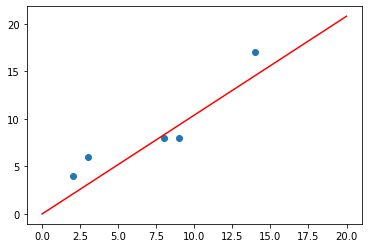

In [50]:
x = [2, 3, 8, 9, 14]
y = [4, 6, 8, 8, 17]
plt.scatter(x,y)
x = [0, 20]
y = [0, 226*20/237 + 137 / 79]
plt.plot(x, y, color = 'red')

find the ecliptical regression for the following data points

| x | y |
|---|---|
| 0 | 2 |
| 2 | 1 |
| 1 |-1 |
|-1 |-2 |
|-1 |-1 |

equation for an elipse is

$$x^2 + v_1 y^2 + v_2 x y + v_3 x + v_4 y + v_5 = 0$$

$$(0)^2 + v_1(2)^2 + v_2(0)(2) + v_3(0) + v_4(2) + v_5 = 0$$
$$(2)^2 + v_1(1)^2 + v_2(2)(1) + v_3(2) + v_4(1) + v_5 = 0$$
$$(1)^2 + v_1(−1)^2 + v_2(1)(−1) + v_3(1) + v_4(−1) + v_5 = 0$$
$$(−1)^2 + v_1(−2)^2 + v_2(−1)(−2) + v_3(−1) + v_4(−2) + v_5 = 0$$
$$(−3)^2 + v_1(1)^2 + v_2(−3)(1) + v_3(−3) + v_4(1) + v_5 = 0$$
$$(−1)^2 + v_1(−1)^2 + v_2(−1)(−1) + v_3(−1) + v_4(−1) + v_5 = 0$$

so we must solve for v

$$A=\begin{bmatrix}
4 & 0 & 0 & 2 & 1\\
1 & 2 & 2 & 1 & 1\\
1 & -1 & 1 & -1 & 1\\
4 & 2 & -1 & -2 & 1\\
1 & -3 & -3 & 1 & 1\\
1 & 1 & -1 & -1 & 1\\
\end{bmatrix} v=\begin{bmatrix}
v_1 \\
v_2 \\
v_3 \\
v_4 \\
v_5
\end{bmatrix}b=\begin{bmatrix}
0\\
-4\\
-1\\
-1\\
9\\
-1
\end{bmatrix}$$

where $$Av ≈ b$$

In [51]:
A = np.array([[4, 0, 0, 2, 1],
              [1, 2, 2, 1, 1],
              [1, -1, 1, -1, 1],
              [4, 2, -1, -2, 1],
              [1, -3, -3, 1, 1],
              [1, 1, -1, -1, 1]])
b = np.array([0, -4, -1, -1, -9, -1])
least_squares(A, b)

A^T * A


<IPython.core.display.Latex object>

A^T * b


<IPython.core.display.Latex object>

Fuse A^T * A with A^T * b


<IPython.core.display.Latex object>

Subtract 7/36 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract -5/36 times row 1 from row 3


<IPython.core.display.Latex object>

Subtract 1/3 times row 1 from row 5


<IPython.core.display.Latex object>

Subtract 359/635 times row 2 from row 3


<IPython.core.display.Latex object>

Subtract -36/127 times row 2 from row 4


<IPython.core.display.Latex object>

Subtract -48/635 times row 2 from row 5


<IPython.core.display.Latex object>

Subtract 2430/6139 times row 3 from row 4


<IPython.core.display.Latex object>

Subtract 267/6139 times row 3 from row 5


<IPython.core.display.Latex object>

Subtract -557/9278 times row 4 from row 5


<IPython.core.display.Latex object>

Divide row 5 by 8574/4639


<IPython.core.display.Latex object>

Subtract -3342/6139 times row 5 from row 4


<IPython.core.display.Latex object>

Subtract 267/635 times row 5 from row 3


<IPython.core.display.Latex object>

Subtract -4/3 times row 5 from row 2


<IPython.core.display.Latex object>

Subtract 12 times row 5 from row 1


<IPython.core.display.Latex object>

Divide row 4 by 55668/6139


<IPython.core.display.Latex object>

Subtract 486/127 times row 4 from row 3


<IPython.core.display.Latex object>

Subtract -5 times row 4 from row 2


<IPython.core.display.Latex object>

Divide row 3 by 6139/635


<IPython.core.display.Latex object>

Subtract 359/36 times row 3 from row 2


<IPython.core.display.Latex object>

Subtract -5 times row 3 from row 1


<IPython.core.display.Latex object>

Divide row 2 by 635/36


<IPython.core.display.Latex object>

Subtract 7 times row 2 from row 1


<IPython.core.display.Latex object>

Divide row 1 by 36


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

$$x^2 + \frac{10355}{8574} y^2 + \frac{-102}{1429} x y + \frac{1623}{1429} x + \frac{-2499}{2858} y + \frac{-20113}{4287} = 0$$
if we multiply everything by 8574 we get
$$8574 x^2 + 10355 y^2 - 612 x y + 9738 x - 7497 y - 40226 = 0$$

In [52]:
x, y = symbols('x y')
solve(8574 * x ** 2 + 10355 * y ** 2 - 612 * x * y + 9738 * x -7497 * y - 40226, x)

[51*y/1429 - sqrt(-88690134*y**2 + 61299450*y + 368604885)/8574 - 1623/2858,
 51*y/1429 + sqrt(-88690134*y**2 + 61299450*y + 368604885)/8574 - 1623/2858]

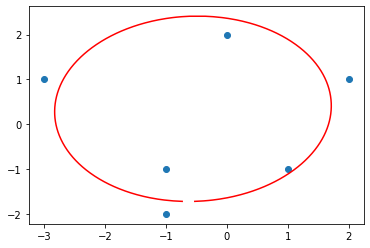

In [53]:
x_vals = []
y_vals = []
for y in range(-300, 300):
    y_guess = y / 100
    x_guess = 51 * y_guess / 1429 - sqrt(-88690134 * y_guess ** 2 + 61299450 * y_guess + 368604885) / 8574 - 1623 / 2858
    if re(x_guess) == x_guess:
        x_vals += [x_guess]
        y_vals += [y_guess]
for y in range(300, -300, -1):
    y_guess = y / 100
    x_guess = 51 * y_guess / 1429 + sqrt(-88690134 * y_guess ** 2 + 61299450 * y_guess + 368604885) / 8574 - 1623 / 2858
    if re(x_guess) == x_guess:
        x_vals += [x_guess]
        y_vals += [y_guess]
plt.plot(x_vals, y_vals, color = 'red')
x_values = [0,2,1,-1,-3,-1]
y_values = [2,1,-1,-2,1,-1]
plt.scatter(x_values, y_values)

In [54]:
#your code here

# 12. TRACE

In [55]:
def trace(A, output = False):
    """
    finds the trace of a matrix
    Parameters
    ----------
    A: array_like
        Matrix in quesiton
    output: bool
        if True, trace() will actually return the trace
    Returns
    -------
    trace: sympy.core.number
        the trace of the matrix
    """
    Y = A.shape
    if Y[0] != Y[1]:
        raise ValueError('A is not square matrix therefore it has no trace')
    work = ''
    R = preprocess(A)
    trace = 0
    for i in range(Y[0]):
        trace += R[i][i]
        work += str(R[i][i]) + ' + '
    display(Latex('$$trace(A) = ' + work[:-3] + '=' + str(trace) + '$$'))
    if output:
        return trace

#### example:

find the trace of the matrix
$$A=\begin{bmatrix}
1 & 2 & 3\\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}$$



In [56]:
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
trace(A)

<IPython.core.display.Latex object>

In [57]:
#your code here

# 13. QR DECOMPOSITION

In [58]:
def qr(A, output = False):
    """
    finds the qr decomposition of a matrix
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, qr() will actually return the Q and R matrices
    Returns
    -------
    Q: array_like
        Q matrix
    R: array_like
        R matrix
    """
    Y = A.shape
    A_clone = preprocess(A)
    Q = np.empty(Y, dtype = sp.core.numbers.Rational)
    print('Construct Q')
    for i in range(Y[1]):
        Q[:,i] = A_clone[:,i]
        display(Latex('$$' + latex(sp.Matrix(Q)) + '$$'))
        for j in range(i):
            c = A_clone[:,i] @ Q[:,j] / (Q[:,j] @ Q[:,j])
            Q[:,i] -= c * Q[:,j]
            print('Subtract ' + str(c) + ' times column ', str(j + 1), ' from column ', str(i + 1))
            display(Latex('$$' + latex(sp.Matrix(Q)) + '$$'))
    display(Latex('$$' + latex(sp.Matrix(Q)) + '$$'))
    roots = np.zeros(Y[1], dtype = sp.core.numbers.Rational)
    for i in range(Y[1]):
        for j in range(Y[0]):
            roots[i] += Q[j][i] ** 2
    for i in range(Y[1]):
        Q[:,i] /= sqrt(roots[i])
    print('Normalize to get Q =')
    display(Latex('$$' + latex(sp.Matrix(Q)) + '$$'))
    print('Compute Q^T*A to get R =')
    R = Q.T @ A_clone
    display(Latex('$$' + latex(sp.Matrix(R)) + '$$'))
    if output:
        return Q, R

#### example:
Calculate the QR decomposition for the matrix 
$$A=\begin{bmatrix}
1 & 2 & 3\\
-1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}$$

In [59]:
A = np.array([[1, 2, 3],
              [-1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]])
qr(A)

Construct Q


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Subtract 3/4 times column  1  from column  2


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Subtract 1 times column  1  from column  3


<IPython.core.display.Latex object>

Subtract 24/19 times column  2  from column  3


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Normalize to get Q =


<IPython.core.display.Latex object>

Compute Q^T*A to get R =


<IPython.core.display.Latex object>

In [60]:
#your code here

# 14. EIGENVALUES AND EIGENVECTORS

In [61]:
def eigensolve(A, output = False):
    """
    used for finding the eigenvectors solves for a span given 
    Parameters
    ----------
    A: array_like
        row reduced form of a matrix denoting the span of an eigenvalue
    output: bool
        if True, eigensolve() will actually return the span
    Returns
    -------
    span: array_like
        the span of the eigenvalue
    """
    Y = A.shape
    A_clone = preprocess(A)
    row_rank = rank(A_clone, output = True, statement = False)
    if row_rank == Y[0]:
        display(Latex('$$' + latex(sp.Matrix(A_clone[:,-1])) + '$$'))
        return A_clone[:,-1]
    span = np.empty((Y[0] - row_rank, Y[1] - 1), dtype = sp.core.numbers.Rational)
    span_print = '$$ span('
    for batch in range(Y[0] - row_rank):
        solver = np.empty((Y[1],), dtype = sp.core.numbers.Rational)
        for i in range(Y[1]):
            solver[i] = Rational(0,1)
        solver[-2 - batch] = Rational(1,1)
        for i in range(Y[0] - 2 - batch, -1, -1):
            solver[i] = A_clone[:,-1][i] - (solver @ A_clone[i])
        span_print += latex(sp.Matrix(solver[:-1])) + ', '
        span[batch] = solver[:-1]
    display(Latex(span_print[:-2] + ')$$'))
    if output:
        return span
    
def eigenvalues(A, output = False):
    """
    finds the eigenvalues of a matrix
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, eigenvalues() will actually return the eigenvalues
    Returns
    -------
    factors: array_like
        the eigenvalues of the matrix
    """
    Y = A.shape
    if Y[0] != Y[1]:
        raise ValueError('A non-square matrix has no eigenvalues')
    else:
        R = preprocess(A)
        eigenspace = np.empty(Y, dtype = fractions.Fraction)
        λ = symbols('λ')
        A_λI = R - λ * preprocess(np.eye(Y[0], Y[0]))
        display(Latex('$$' + latex(sp.Matrix(A_λI)) + '$$'))
        print('Solve for λ')
        factors = solve(det_recursive(A_λI), λ)
        for λ in factors:
            display(Latex('$$λ = ' + str(λ) + '$$'))
        n = 0
    if output:
        return factors
        
def eigenset(A, output = False):
    """
    finds the eigenvalues and eigenvectors of a matrix
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, eigenset() will actually return the eigenvalues and eigenvectors
    Returns
    -------
    eigenspace: array_like
        the eigenvectors of the matrix
    eigenvalues: array_like
        the eigenvalues of the matrix
    """
    Y = A.shape
    if Y[0] != Y[1]:
        raise ValueError('A non-square matrix has no eigenvalues')
    else:
        R = preprocess(A)
        eigenspace = np.empty(Y, dtype = fractions.Fraction)
        λ = symbols('λ')
        A_λI = R - λ * preprocess(np.eye(Y[0], Y[0]))
        display(Latex('$$' + latex(sp.Matrix(A_λI)) + '$$'))
        print('Solve for λ')
        factors = solve(det_recursive(A_λI), λ)
        for λ in factors:
            display(Latex('$$λ = ' + str(λ) + '$$'))
        n = 0
        eigenvalues = []
        for λ in factors:
            B = R - λ * preprocess(np.eye(Y[0], Y[1]))
            print('B = ')
            display(Latex('$$' + latex(sp.Matrix(B)) + '$$'))
            print('Solve Bv = 0')
            B = preprocess(np.concatenate((B, np.zeros((Y[0], 1), dtype = int)), axis = 1))
            display(Latex('$$' + latex(sp.Matrix(B)) + '$$'))
            B_red = rowred(B, rref = True, output = True)
            print('For eigenvalue ' + str(λ) + ' we have eigenspace')
            eigenvectors = eigensolve(B_red, output = True)
            for vectors in eigenvectors:
                eigenspace[n] = vectors
                eigenvalues += [λ]
                n += 1
    if output:
        return eigenspace, eigenvalues
    


#### example:
Please note that computing eigenvalues using a computer is an extremely complex problem with many complex methods. Most likely your linear algebra class would never ask you to compute the eigenvalues for anything larger than a 3x3. eigenstuff() mirrors what a human would do but is far from the most efficient way to compute eigenvalues and eigenspaces.

In [62]:
A = np.array([[-1, 2, 2],
              [2, 2, -1],
              [2, -1, 2]])
x = eigenset(A, output = True)

<IPython.core.display.Latex object>

Solve for λ


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

B = 


<IPython.core.display.Latex object>

Solve Bv = 0


<IPython.core.display.Latex object>

Subtract 1 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract 1 times row 1 from row 3


<IPython.core.display.Latex object>

Subtract -1 times row 2 from row 3


<IPython.core.display.Latex object>

Divide row 2 by 3


<IPython.core.display.Latex object>

Subtract 2 times row 2 from row 1


<IPython.core.display.Latex object>

Divide row 1 by 2


<IPython.core.display.Latex object>

For eigenvalue -3 we have eigenspace


<IPython.core.display.Latex object>

B = 


<IPython.core.display.Latex object>

Solve Bv = 0


<IPython.core.display.Latex object>

Subtract -1/2 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract -1/2 times row 1 from row 3


<IPython.core.display.Latex object>

Divide row 1 by -4


<IPython.core.display.Latex object>

For eigenvalue 3 we have eigenspace


<IPython.core.display.Latex object>

# 15. DIAGONALIZATION

In [63]:
def diagonalize(A, output = False):
    """
    finds the diagonization of a matrix
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, diagonalize() will actually return the X ^ -1, A, X and D matrices 
    Returns
    -------
    X_inverse: array_like
        inverse of X matrix for diagonalization
    A: array_like
        original input matrix
    X: aray_like
        X matrix for diagonalization
    D: array_like
        D matrix for diagonalization
    """
    A_clone = preprocess(A)
    X = eigenset(A_clone, output = True)[0].T
    display(Latex('$$X^{-1}AX = D$$'))
    display(Latex('$$X^{-1}: $$'))
    X_inverse = preprocess(inverse(X, output = True))
    display(Latex('$$D:$$'))
    D = X_inverse @ A @ X
    display(Latex('$$' + latex(sp.Matrix(X_inverse)) + ' ⋅ ' 
                  + latex(sp.Matrix(A_clone)) + ' ⋅ ' 
                  + latex(sp.Matrix(X)) + ' = '
                  + latex(sp.Matrix(D)) + '$$'))
    display(Latex('$$X^{-1}=' + latex(sp.Matrix(X_inverse)) + '$$'))
    display(Latex('$$A=' + latex(sp.Matrix(A)) + '$$'))
    display(Latex('$$X=' + latex(sp.Matrix(X)) + '$$'))
    display(Latex('$$D=' + latex(sp.Matrix(D)) + '$$'))
    if output:
        return X_inverse, A, X, D

In [64]:
A = np.array([[-1, 2, 2],
              [2, 2, -1],
              [2, -1, 2]])
diagonalize(A)

<IPython.core.display.Latex object>

Solve for λ


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

B = 


<IPython.core.display.Latex object>

Solve Bv = 0


<IPython.core.display.Latex object>

Subtract 1 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract 1 times row 1 from row 3


<IPython.core.display.Latex object>

Subtract -1 times row 2 from row 3


<IPython.core.display.Latex object>

Divide row 2 by 3


<IPython.core.display.Latex object>

Subtract 2 times row 2 from row 1


<IPython.core.display.Latex object>

Divide row 1 by 2


<IPython.core.display.Latex object>

For eigenvalue -3 we have eigenspace


<IPython.core.display.Latex object>

B = 


<IPython.core.display.Latex object>

Solve Bv = 0


<IPython.core.display.Latex object>

Subtract -1/2 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract -1/2 times row 1 from row 3


<IPython.core.display.Latex object>

Divide row 1 by -4


<IPython.core.display.Latex object>

For eigenvalue 3 we have eigenspace


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Subtract -1/2 times row 1 from row 2


<IPython.core.display.Latex object>

Subtract -1/2 times row 1 from row 3


<IPython.core.display.Latex object>

Subtract 5 times row 2 from row 3


<IPython.core.display.Latex object>

Divide row 3 by -6


<IPython.core.display.Latex object>

Subtract 5/4 times row 3 from row 2


<IPython.core.display.Latex object>

Subtract 1/2 times row 3 from row 1


<IPython.core.display.Latex object>

Divide row 2 by 1/4


<IPython.core.display.Latex object>

Subtract 1/2 times row 2 from row 1


<IPython.core.display.Latex object>

Divide row 1 by -2


<IPython.core.display.Latex object>

The inverse is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [65]:
#your code here

# 16. POSITIVE DEFINITENESS

In [66]:
def is_pd_eig(A, output = False):
    """
    determines whether a matrix is positive definite by checking
    if all of its eigenvalues are greater than 0
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, returns a boolean
    Returns
    -------
    is_pd: bool
        True if A is positive definite False if A is not
    """
    Y = A.shape
    if Y[0] != Y[1]:
        print('A non square matrix is not positive definite')
        display(Latex('$$False$$'))
        if output:
            return False
    A_clone = preprocess(A)
    factors = eigenvalues(A_clone, output = True)
    is_pd = True
    for i in factors:
        if i <= 0:
            is_pd = False
            display(Latex('$$' + str(i) + '<= 0$$'))
            display(Latex('$$False$$'))
    if is_pd:
        print('All eigenvalues are positive')
        display(Latex('$$True$$'))
    if output:
        return is_pd

def is_pd_det(A, output = False):
    """
    determines whether the matrix is positive definite using Sylvester's criterion
    Parameters
    ----------
    A: array_like
        Matrix in question
    output: bool
        if True, returns a boolean
    Returns
    -------
    is_pd: bool
        True if A is positive definite False if A is not
    """
    Y = A.shape
    if Y[0] != Y[1]:
        print('A non square matrix is not positive definite')
        display(Latex('$$False$$'))
        if output:
            return False
    A_clone = preprocess(A)
    is_pd = True
    for i in range(Y[1]):
        det = det_recursive(A_clone[:i + 1,:i + 1])
        display(Latex('$$det(' + latex(sp.Matrix(A_clone[:i + 1,:i + 1])) + ')$$'))
        if det <= 0:
            is_pd = False
            display(Latex('$$' + str(det) + '<= 0$$'))
            display(Latex('$$False$$'))
            break
        else:
            display(Latex('$$' + str(det) + '> 0$$'))
    if is_pd:
        print('All eigenvalues are positive')
        display(Latex('$$True$$'))
    if output:
        return is_pd

#### example:

In [67]:
A = np.array([[1, 2, 2],
              [2, 2, -3],
              [2, -1, 2]])
is_pd_det(A)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [68]:
A = np.array([[-1, 2, 2],
              [2, 2, -1],
              [2, -1, 2]])
is_pd_eig(A)

<IPython.core.display.Latex object>

Solve for λ


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [69]:
#your code here